In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import matplotlib.dates as mdates
import re
from scipy.interpolate import interp1d

# 1. Change directory to raw data folder

In [2]:
# Get the current working directory
current_directory = os.getcwd()

# Get the parent directory by going one level up
parent_directory = os.path.dirname(current_directory)

# Get the path of raw data folder
data_raw_folder = os.path.join(parent_directory, 'data/raw')

# Change the current working directory to raw data folder
os.chdir(data_raw_folder)

# 2. Import datasets

In [3]:
# New issues data
new_issues = pd.read_csv('new_issues.csv', index_col=0)
new_issues_characteristics =  pd.read_csv('new_issues_characteristics.csv', index_col=0)
new_issues_prices_refinitive =  pd.read_csv('new_issues_prices_askyield_refinitive.csv', index_col=0)
swap_rates = pd.read_csv('swap_rates.csv', index_col=0)

In [4]:
# Index data
iboxx_indices = pd.read_csv('iboxx_indices.csv', sep=';')
move_index = pd.read_csv('move_index.csv')

In [5]:
# Comparable bonds
chunk_dfs = []
for i in range(7):
    chunk_df = pd.read_csv(f'comparable_bonds_iboxx_{i+1}.csv', index_col=0)
    chunk_dfs.append(chunk_df)

# Concatenate all the chunk dataframes into one dataframe
comparable_bonds_iboxx = pd.concat(chunk_dfs, ignore_index=True)
comparable_bonds_prices = pd.read_csv('comparable_bonds_filtered_yield.csv', index_col=0)
comparable_bonds_prices_hourly = pd.read_csv('comparable_bonds_hourly_prices.csv', index_col=0)

# 3. Modify raw datasets and create subsets

## 3.1 New issues

In [6]:
# Create new issues dataframe with selected columns
new_issues_sliced = new_issues.loc[:,['securities_isin', 'ticker', 'dealDate',
                                      'issuerType', 'paymentType', 'countryName', 'COUNTRY_ISO_CODE', 
                                      'moodys', 'sp', 'fitch', 'expectedSize', 'actualSize', 'minimumDenomination', 
                                      'securityType', 'maturityTerm', 'coupon', 'seniority_name_1', 
                                      'seniority_name_1_adj', 'esgType', 'referenceType', 'ipt_reference',
                                      'ipt_price_down', 'ipt_price_up', 'guidance_reference', 'guidance_price_down',
                                      'guidance_price_up', 'launchValue', 'reofferValue', 'reofferPrice', 'yieldToMaturity',
                                     'Industry_Group', 'Industry_Sector']]

# Change time type
new_issues_sliced['dealDate'] = pd.to_datetime(new_issues_sliced['dealDate'])
new_issues_sliced['dealDate'] = new_issues_sliced['dealDate'].dt.floor('d')

In [7]:
# Check for duplicated combinations
duplicates = new_issues_sliced.duplicated(subset=['securities_isin', 'dealDate'], keep=False)

# Drop the duplicated combinations
new_issues_sliced = new_issues_sliced[~duplicates]

In [8]:
# Deal with duplicated isins

# Sort the DataFrame by 'dealDate' in ascending order
new_issues_sliced = new_issues_sliced.sort_values('dealDate')

# Keep the first occurrence of each ISIN
new_issues_sliced = new_issues_sliced.drop_duplicates('securities_isin', keep='first')

## 3.2 Comparable bonds

In [9]:
comparable_bonds_iboxx['date'] = pd.to_datetime(comparable_bonds_iboxx['date'])
comparable_bonds_iboxx['date'] = comparable_bonds_iboxx['date'].dt.floor('d')

In [10]:
comparable_bonds_prices['Date'] = pd.to_datetime(comparable_bonds_prices['Date'])
comparable_bonds_prices['Date'] = comparable_bonds_prices['Date'].dt.date
comparable_bonds_prices['Date'] = comparable_bonds_prices['Date'].astype('datetime64')
comparable_bonds_prices['Date'] = comparable_bonds_prices['Date'].dt.floor('d')

## 3.3 New issues characteristics; New issues prices

In [11]:
# Merge new issues with corresponding payment ranks
new_issues_sliced = new_issues_sliced.merge(new_issues_characteristics[['security', 'PAYMENT_RANK']], left_on = 'securities_isin', right_on = 'security', how = 'inner')
new_issues_sliced = new_issues_sliced.drop(['security'], axis=1)

In [12]:
# Change time type in refinitive prices dataset
new_issues_prices_refinitive['Date'] = pd.to_datetime(new_issues_prices_refinitive['Date'])
new_issues_prices_refinitive['Date'] = new_issues_prices_refinitive['Date'].dt.date
new_issues_prices_refinitive['Date'] = new_issues_prices_refinitive['Date'].astype('datetime64')
new_issues_prices_refinitive['Date'] = new_issues_prices_refinitive['Date'].dt.floor('d')

# Rename column
new_issues_prices_refinitive = new_issues_prices_refinitive.rename(columns={'Instrument': 'isin', 'Date': 'date'})

In [13]:
# Filter out 'wrong' prices (EUR price instead of yield)
new_issues_prices_refinitive = new_issues_prices_refinitive[(abs(new_issues_prices_refinitive['Ask Yield']) < 10) | (new_issues_prices_refinitive['Ask Yield'].isna())]

## 3.4 Create dataframe of initial YTMs of new issues

In [14]:
# MS spread from IPREO data
new_issues_yield_ipreo = new_issues_sliced.loc[:, ['dealDate', 'securities_isin', 'ticker', 'maturityTerm', 'PAYMENT_RANK', 'issuerType', 'reofferValue', 'yieldToMaturity']]
new_issues_yield_ipreo = new_issues_yield_ipreo.rename(columns={'securities_isin': 'isin'})
new_issues_yield_ipreo = new_issues_yield_ipreo.drop_duplicates()

In [15]:
# Keep new issues with known initial MS
new_issues_initial_prices = new_issues_yield_ipreo.loc[~new_issues_yield_ipreo['yieldToMaturity'].isna(), :]

In [16]:
new_issues_initial_prices = new_issues_initial_prices.reset_index(drop=True)

## 3.4 Find comparable bonds at the day of the issue

In [17]:
# Merge initial YTM of comparable bonds at the dealDate
new_issues_with_comp = new_issues_initial_prices.merge(comparable_bonds_iboxx, left_on=['ticker', 'dealDate'], right_on=['ticker', 'date'], how='inner')

In [18]:
# Keep comparable bonds with the same payment rank
new_issues_with_comp = new_issues_with_comp[new_issues_with_comp['PAYMENT_RANK']==new_issues_with_comp['Payment_Rank']]
new_issues_with_comp = new_issues_with_comp.reset_index()

In [19]:
# Find the comparable bond with the closest maturity

# Sort the dataframe
new_issues_with_comp = new_issues_with_comp.sort_values(by=['isin', 'dealDate'])

# Group the dataframe
new_issues_with_comp_grouped = new_issues_with_comp.groupby(['isin', 'dealDate'])

# Function to find closest maturity
def find_closest_maturity(group):
    group['maturity_diff'] = group['Time_To_Maturity'] - group['maturityTerm']
    group['maturity_diff_abs'] = abs(group['maturity_diff'])
    closest_row = group.loc[group['maturity_diff_abs'].idxmin()]
    return closest_row

# Dataframe with closest maturities
new_issues_with_comp_filtered = new_issues_with_comp_grouped.apply(find_closest_maturity).reset_index(drop=True)

## 3.5 Keep issues with the prices for comparable bonds

In [20]:
comparable_bonds_prices_hourly_isins = [isin for isin in comparable_bonds_prices_hourly['ISIN'].unique()]

In [21]:
new_issues_with_comp_filtered_2023 = new_issues_with_comp_filtered[new_issues_with_comp_filtered['ISIN'].isin(comparable_bonds_prices_hourly_isins)]
new_issues_with_comp_filtered_2023 = new_issues_with_comp_filtered_2023[new_issues_with_comp_filtered_2023['dealDate'] > '2023-01-01']

## 3.6 Swap rates

In [22]:
# Extract the column names and their corresponding years
columns = swap_rates.columns
years = []

# Determine if the column represents months or years and extract the corresponding number
for col in columns:
    match = re.search(r'(\d+)([YM])=', col)
    if match:
        num = int(match.group(1))
        unit = match.group(2)
        if unit == 'Y':
            years.append(num)
        elif unit == 'M':
            years.append(num / 12)
            
# Create a dictionary to map the old column names to the new column names
new_columns = {col: yr for col, yr in zip(columns, years)}

# Rename the columns in the DataFrame
swap_rates.rename(columns=new_columns, inplace=True)

# Sort the columns in ascending order
swap_rates = swap_rates.reindex(sorted(swap_rates.columns), axis=1)

# Change time type in refinitive prices dataset
swap_rates = swap_rates.reset_index()
swap_rates['Date'] = pd.to_datetime(swap_rates['Date'])
swap_rates['Date'] = swap_rates['Date'].dt.date
swap_rates['Date'] = swap_rates['Date'].astype('datetime64')
swap_rates['Date'] = swap_rates['Date'].dt.floor('d')
swap_rates = swap_rates.set_index('Date')

In [23]:
# Extract the maturities from column names
maturities = [col for col in swap_rates.columns]

# Interpolate the swap rate curve for each timestamp
interpolated_swap_rates = {}
for timestamp, row in swap_rates.iterrows():
    swap_rate_interpolator = interp1d(maturities, row, kind='cubic')
    interpolated_swap_rates[timestamp] = swap_rate_interpolator

# 4. Dynamic analysis: HSBC example

In [24]:
hsbc_dynamics = new_issues_with_comp_filtered_2023[new_issues_with_comp_filtered_2023['isin']=='XS2595029344']
hsbc_dynamics = hsbc_dynamics.drop_duplicates()
hsbc_dynamics = hsbc_dynamics.reset_index(drop=True)
hsbc_dynamics = hsbc_dynamics.drop(['date', 'Annual_Yield_to_Maturity'], axis=1)

In [25]:
# Merge the YTM of the comparable bonds
hsbc_dynamics = hsbc_dynamics.merge(comparable_bonds_iboxx[['ISIN', 'date', 'Annual_Yield_to_Maturity']], on='ISIN', how='inner')
hsbc_dynamics = hsbc_dynamics.drop_duplicates()
hsbc_dynamics = hsbc_dynamics.reset_index(drop=True)

In [26]:
# Calculate the corresponding swap rates for comparable bonds
def calculate_swap_rate_bond_comp_dev(row):
    try:
        return interpolated_swap_rates[row['date']](row['Time_To_Maturity'])
    except (KeyError, ValueError):
        return None

hsbc_dynamics['SwapRateCompBond'] = hsbc_dynamics.apply(calculate_swap_rate_bond_comp_dev, axis=1)

In [27]:
# Calculate MS for comparable bonds
hsbc_dynamics['compBondMS'] = hsbc_dynamics['Annual_Yield_to_Maturity'] - hsbc_dynamics['SwapRateCompBond']
hsbc_dynamics['compBondMS'] = hsbc_dynamics['compBondMS'] * 100

In [28]:
# Add price development of new issues
new_issues_prices_refinitive_hsbc_after_settlement = new_issues_prices_refinitive[(new_issues_prices_refinitive['isin']=='XS2595029344') & (new_issues_prices_refinitive['date']>='2023-03-07')]
hsbc_dynamics = hsbc_dynamics.merge(new_issues_prices_refinitive_hsbc_after_settlement, on=['isin', 'date'], how='left')

In [29]:
# Calculate the corresponding swap rates for initial bond
def calculate_swap_rate_bond_comp_dev(row):
    try:
        return interpolated_swap_rates[row['date']](row['maturityTerm'])
    except (KeyError, ValueError):
        return None

hsbc_dynamics['SwapRateNewIssue'] = hsbc_dynamics.apply(calculate_swap_rate_bond_comp_dev, axis=1)

In [30]:
# Keep two weeks before and two weeks after issue
hsbc_dynamics = hsbc_dynamics[(hsbc_dynamics['date'] >= '2023-02-12') & (hsbc_dynamics['date'] <= '2023-03-14')]

In [31]:
# Calculate MS for initial bond
hsbc_dynamics = hsbc_dynamics.copy()
hsbc_dynamics['initialBondMS'] = hsbc_dynamics['Ask Yield'] - hsbc_dynamics['SwapRateNewIssue']
hsbc_dynamics['initialBondMS'] = hsbc_dynamics['initialBondMS'] * 100

In [32]:
# Set the 'date' column as the index
hsbc_dynamics.set_index('date', inplace=True)

In [33]:
# Extract hour prices
comparable_bonds_prices_hourly = comparable_bonds_prices_hourly.reset_index()
comparable_bonds_prices_hourly['Date'] = pd.to_datetime(comparable_bonds_prices_hourly['Date'])
comparable_bonds_prices_hourly.set_index('Date', inplace=True)
hsbc_hourly_dynamics = comparable_bonds_prices_hourly[comparable_bonds_prices_hourly['ISIN']=='FR001400AEA1']
hsbc_hourly_dynamics = hsbc_hourly_dynamics[hsbc_hourly_dynamics.index > '2023-02-28 07:30:00']

In [34]:
hsbc_hourly_dynamics['spread'] = (hsbc_hourly_dynamics['CLOSE'] - 3.3659832794404343) * 100

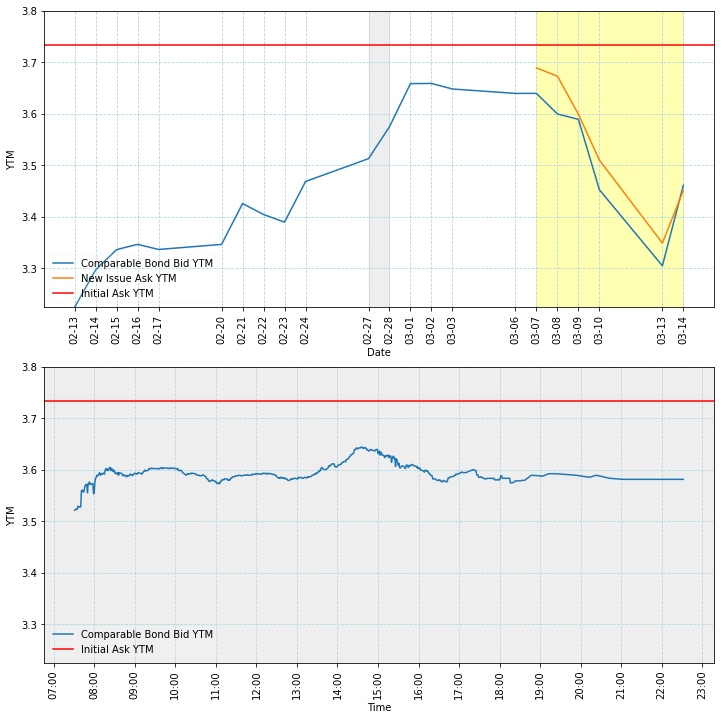

In [35]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharey=True)

y_min = min(hsbc_dynamics['Annual_Yield_to_Maturity'].min(), hsbc_dynamics['Ask Yield'].min())
y_max = max(hsbc_dynamics['Annual_Yield_to_Maturity'].max(), hsbc_dynamics['Ask Yield'].max(), 3.8)

# Plotting the first graph on the left subplot (ax1)
ax1.plot(hsbc_dynamics.index, hsbc_dynamics['Annual_Yield_to_Maturity'], label='Comparable Bond Bid YTM')
ax1.plot(hsbc_dynamics.index, hsbc_dynamics['Ask Yield'], label='New Issue Ask YTM')
ax1.axhline(y=3.734, color='r', linestyle='-', label='Initial Ask YTM')

# Add vertical lines and transparent yellow rectangles
# ax1.axvline(pd.Timestamp('2023-02-27'), color='black', linestyle='-', ymin=0.50, ymax=0.88, linewidth=2)
# ax1.hlines(y=3.734, xmin=pd.Timestamp('2023-02-26'), xmax=pd.Timestamp('2023-02-28'), color='black', linewidth=2)
# ax1.hlines(y=3.512, xmin=pd.Timestamp('2023-02-26'), xmax=pd.Timestamp('2023-02-28'), color='black', linewidth=2)

rect1 = patches.Rectangle((pd.Timestamp('2023-02-27'), y_min), pd.Timedelta(days=1), y_max-y_min, color='grey', alpha=0.13)
ax1.add_patch(rect1)

rect2 = patches.Rectangle((pd.Timestamp('2023-03-07'), y_min), pd.Timedelta(days=7), y_max-y_min, color='yellow', alpha=0.3)
ax1.add_patch(rect2)

# ax1.set_title('Bond Prices')
ax1.set_xlabel('Date')
ax1.set_ylabel('YTM')
ax1.grid(True, color='lightblue', linestyle='--') 
ax1.grid(True)
ax1.legend()

# Plotting the second graph on the right subplot (ax2)
ax2.plot(hsbc_hourly_dynamics.index, hsbc_hourly_dynamics['CLOSE'], label='Comparable Bond Bid YTM')
ax2.axhline(y=3.734, color='r', linestyle='-', label='Initial Ask YTM')

# Add black line at 12:00 on 2023-02-28
# ax2.axvline(pd.Timestamp('2023-02-28 12:00'), color='black', linestyle='-', ymin=0.64, ymax=0.88, linewidth=2)
# ax2.hlines(y=3.734, xmin=pd.Timestamp('2023-02-28 11:30'), xmax=pd.Timestamp('2023-02-28 12:30'), color='black', linewidth=2)
# ax2.hlines(y=3.590, xmin=pd.Timestamp('2023-02-28 11:30'), xmax=pd.Timestamp('2023-02-28 12:30'), color='black', linewidth=2)

# ax2.set_title('Bond Prices Intraday')
ax2.set_xlabel('Time')
ax2.grid(True, color='lightblue', linestyle='--') 
ax2.grid(True)
ax2.legend()

# Set the background color of the right graph as transparent
ax2.patch.set_alpha(0.13)

# Set the facecolor of the right graph to match the color of the rectangle in the left graph
ax2.set_facecolor('grey')

ax1.set_ylim(y_min, y_max)
ax2.set_ylim(y_min, y_max)

# Rotate x-axis labels by 90 degrees for both subplots
ax1.tick_params(axis='x', rotation=90)
ax2.tick_params(axis='x', rotation=90)

# Customize x-axis tick labels on the left subplot
ax1.set_xticks(hsbc_dynamics.index)
ax1.set_xticklabels(hsbc_dynamics.index.strftime('%m-%d'))  # Format tick labels as 'MM-DD'

# Customize x-axis tick labels on the right subplot
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set tick positions to be every hour
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format tick labels as 'HH:MM'

# Remove y-axis label from the right subplot
ax2.set_ylabel('YTM')

# Adjust the spacing between subplots and move labels to the right bottom corner
plt.subplots_adjust(wspace=0.1)
legend_ax1 = ax1.legend(loc='lower left')
legend_ax1.get_frame().set_alpha(0.1)
legend_ax2 = ax2.legend(loc='lower left')
legend_ax2.get_frame().set_alpha(0.1)

# Show the plot
# plt.savefig('price_dynamics.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()